# Gemeinderatswahl 2024 in Freiburg

Hier sage ich die Gemeinderatswahlergbnisse aus Freiburg im Breisgau vorher.

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import os
from matplotlib import pyplot as plt
import json
#import plotly.express as px
#import plotly.graph_objects as go
import geopandas 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')
from functions_wahl import *

In [4]:
#Daten bekommen und kombinieren mit geografischen und statistischen Stadtdaten 
#get_and_save_komm()
Stadtteile,Stadtbezirke=process_geo()
gesamt,comb2,wahl_bezirke=get_process_wahl(final=False)
joined=Stadtbezirke.join(comb2)
gem19_stadtbezirke=get_gem19()

Wahlbezirke 247
ausgezaehlte Wahlbezirke 52


## Gesamtergebnis

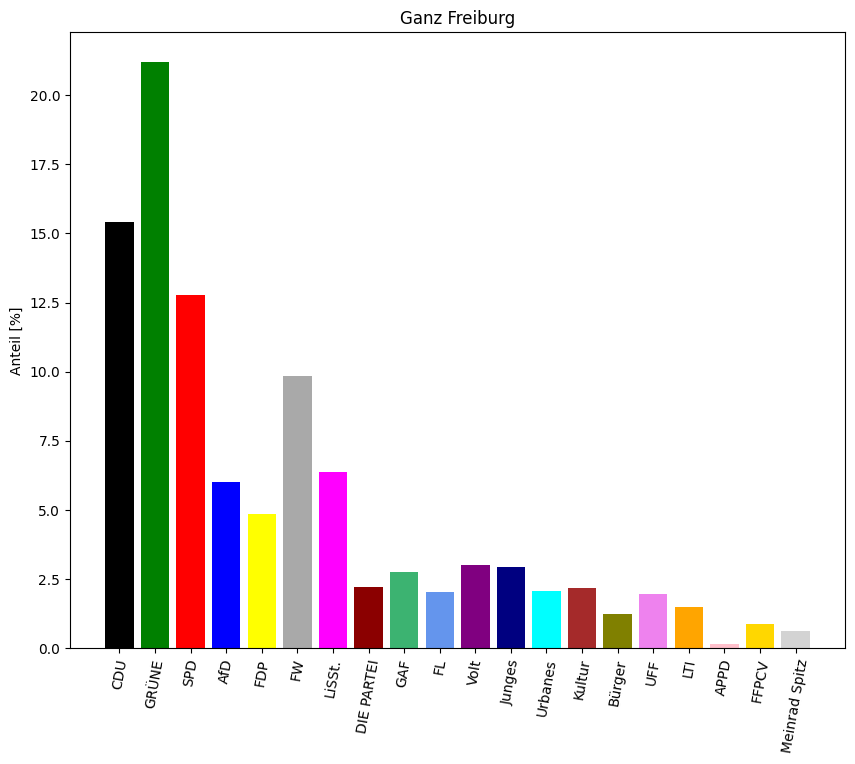

In [5]:
make_bar_plot(gesamt,title='Ganz Freiburg')

 48 wurden zugeteilt wie es sein sollte


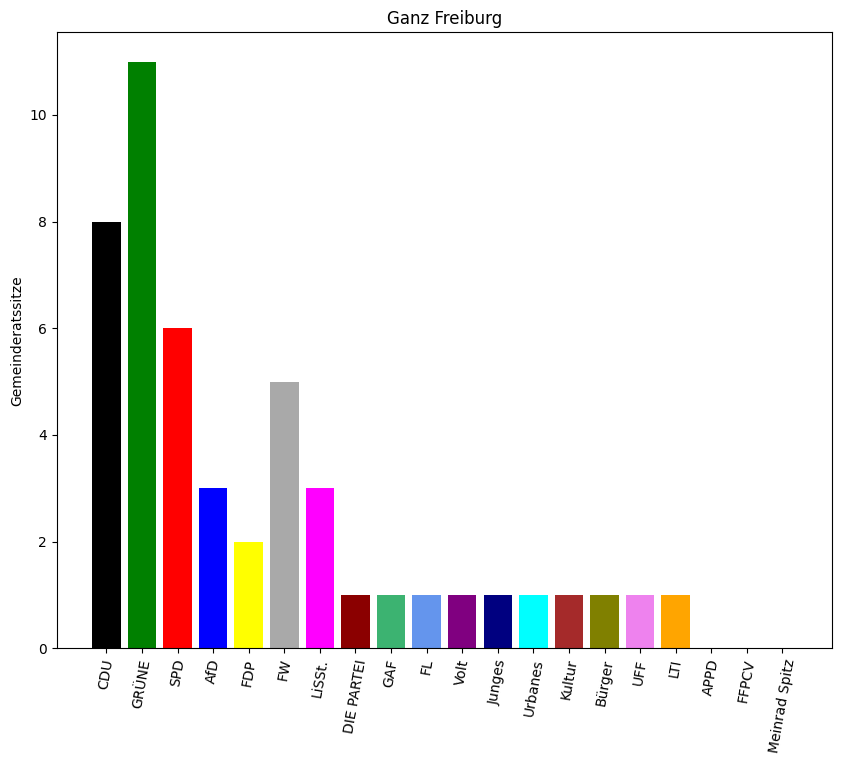

In [6]:
test_res=sainte_l(gesamt.loc[0,:])
make_bar_plot(gesamt,sitze=48,title='Ganz Freiburg')

Dabei ist zu beachten, dass noch lange nicht alles ausgezaehlt ist, darunter Karten wieviel ausgezaehlt ist. 

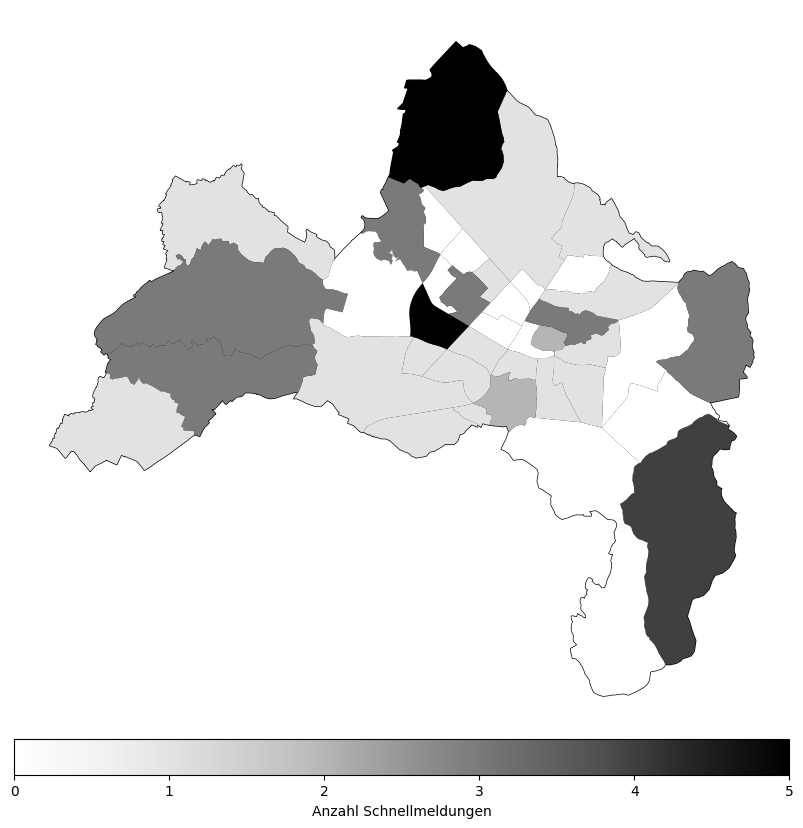

In [7]:
karte_stadtbezirke(joined,'anz-schnellmeldungen')

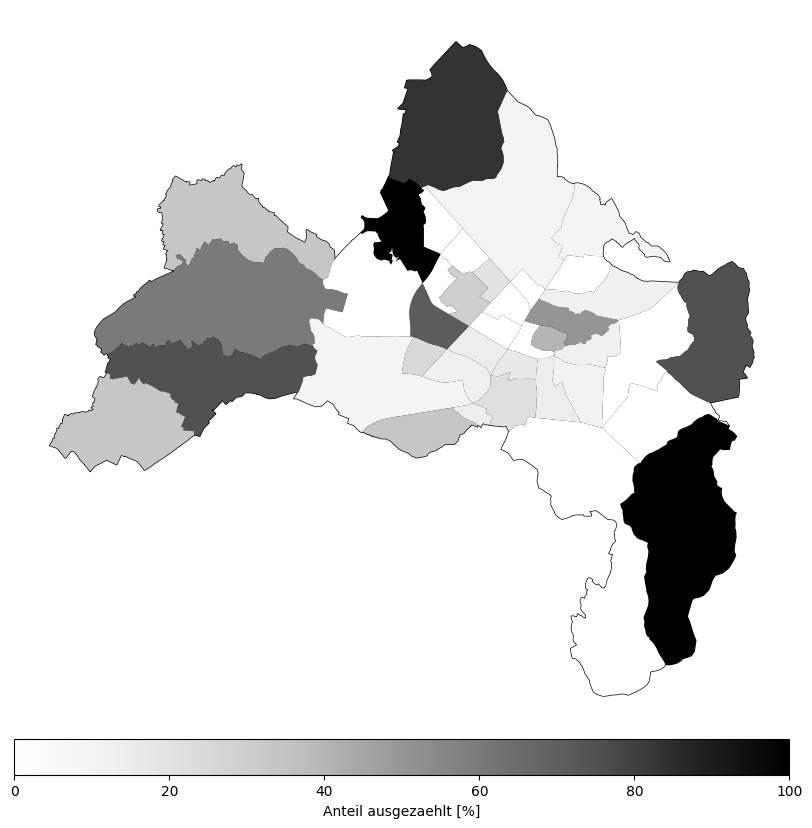

In [8]:
karte_stadtbezirke(joined,'wahlbezirke_prozent')

Nun Karten mit Parteianteil. 

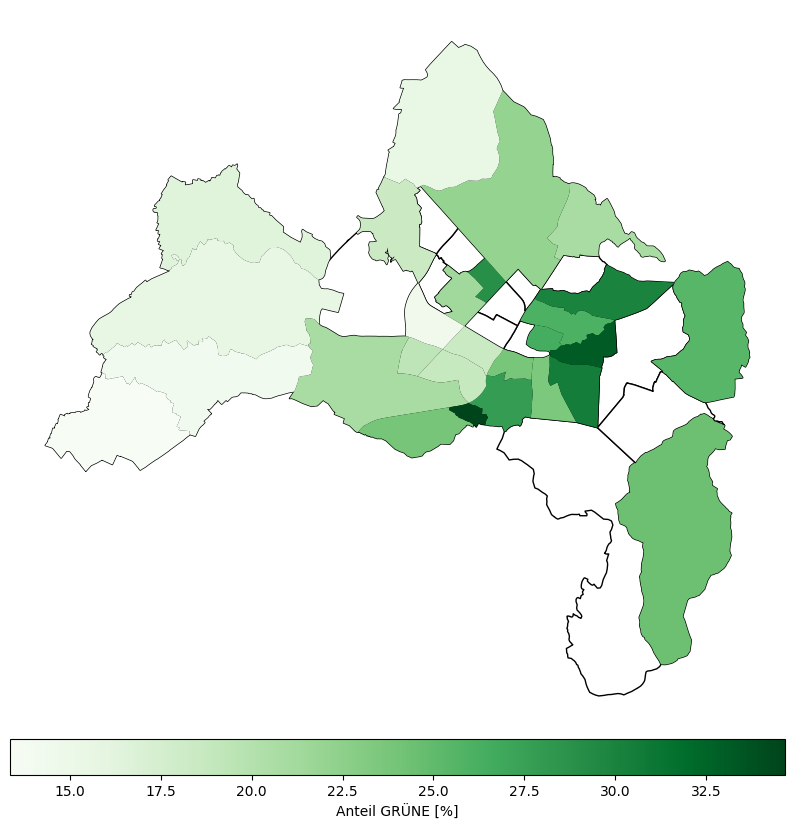

In [9]:
karte_stadtbezirke(joined,'GRÜNE')

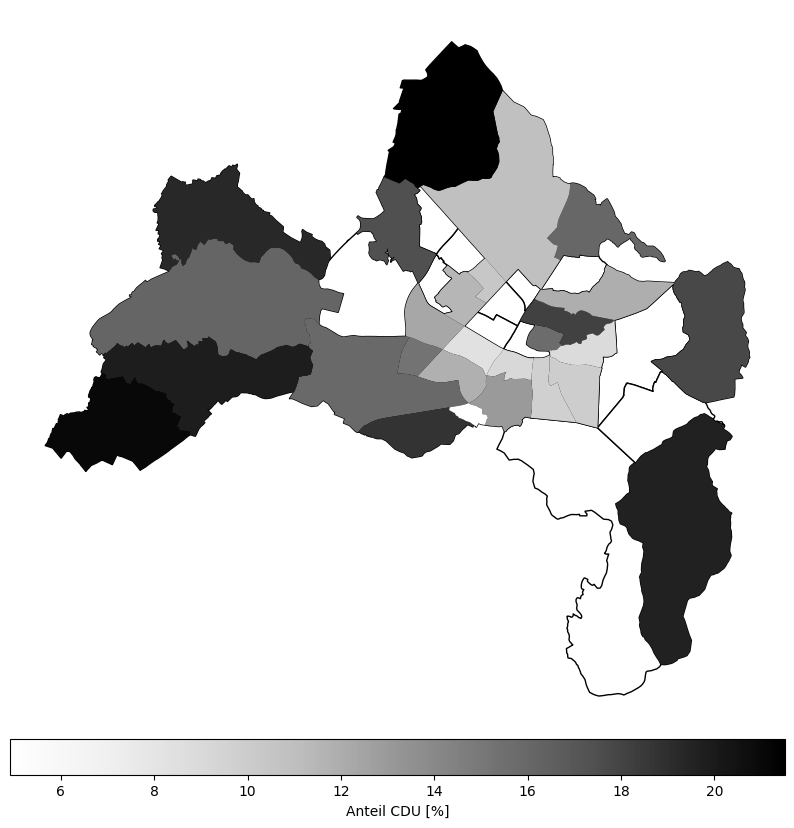

In [10]:
karte_stadtbezirke(joined,'CDU')

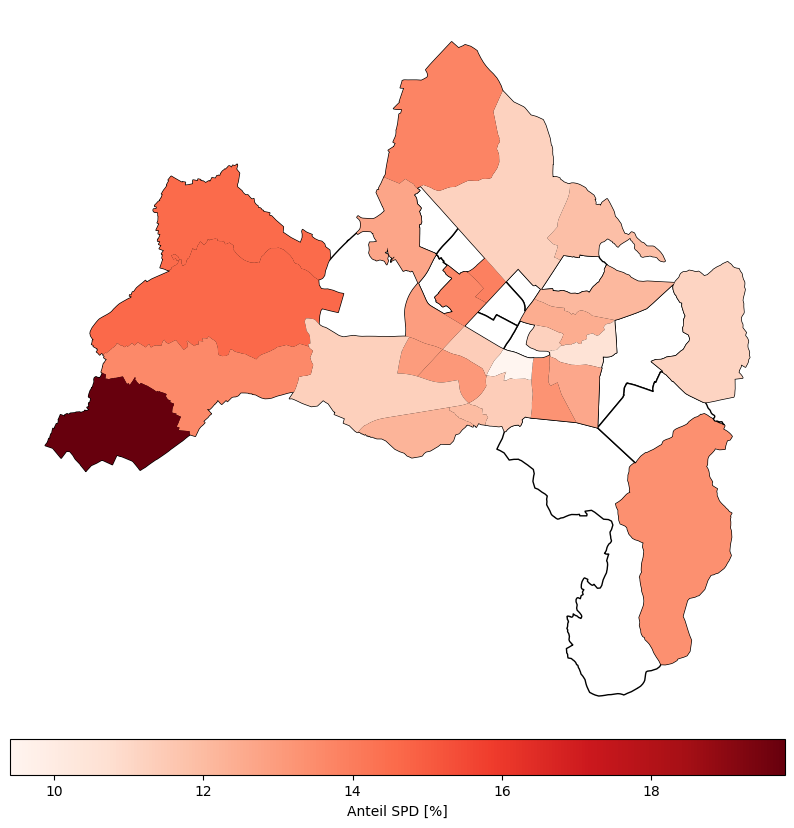

In [11]:
karte_stadtbezirke(joined,'SPD')

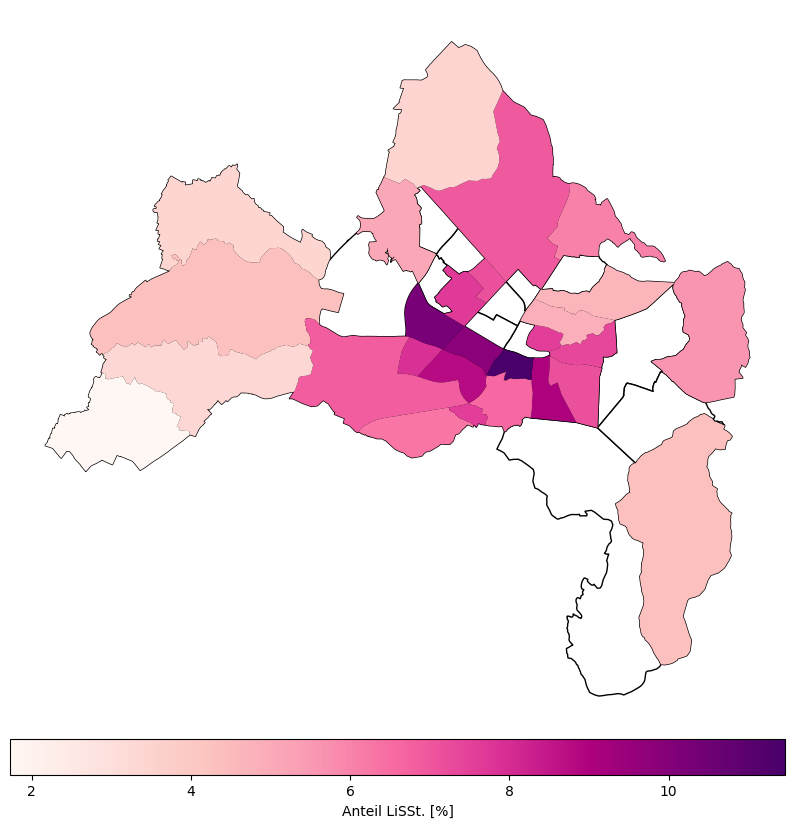

In [12]:
karte_stadtbezirke(joined,'LiSSt.')

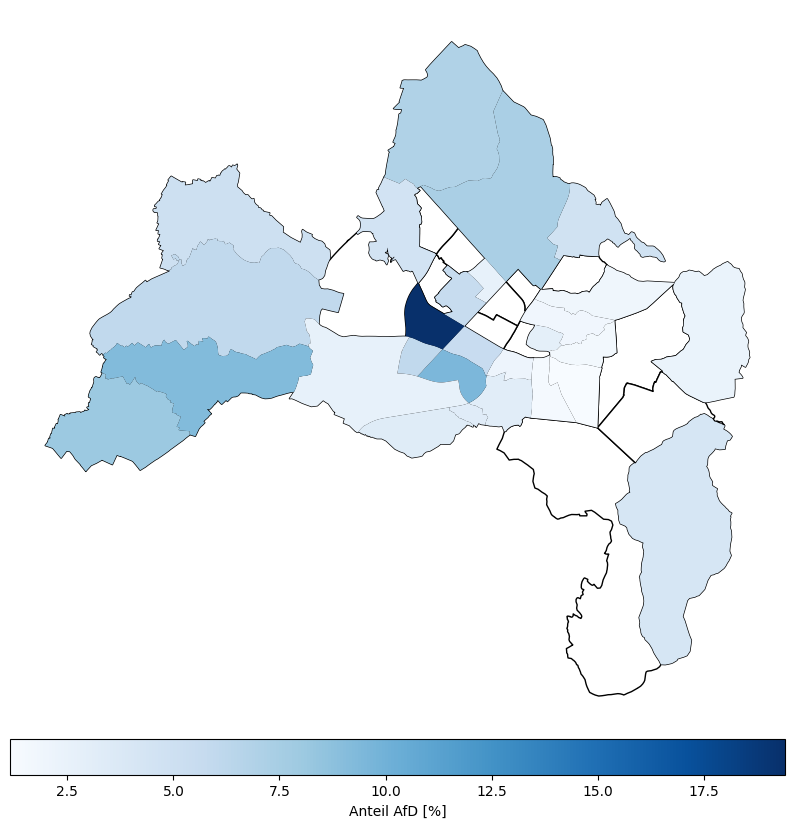

In [13]:
karte_stadtbezirke(joined,'AfD')

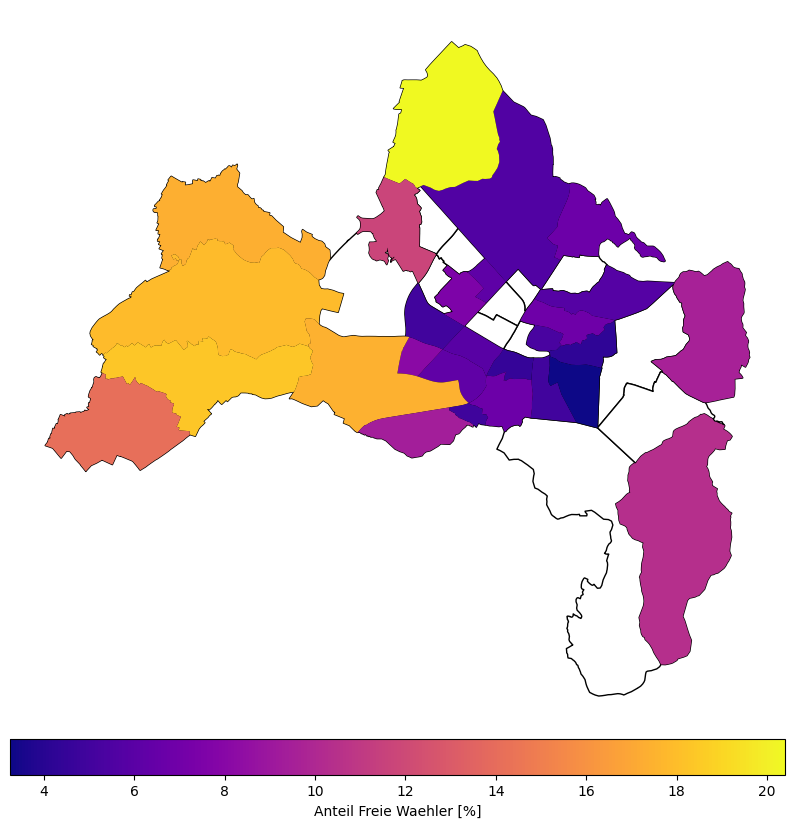

In [14]:
karte_stadtbezirke(joined,'FW')

## Gesamtergebniss Vorhersage.

Die Fertigsten Stadtbezirke helfen um das Gesamtergebnis Vorherzusagen. 

In [15]:
print((comb2.loc[:,'anz-schnellmeldungen']/comb2.loc[:,'max-schnellmeldungen']).sort_values(ascending=False)[0:6])

Stadtbezirk
Lehen         1.000000
Kappel        1.000000
Hochdorf      0.833333
Tiengen       0.750000
Ebnet         0.750000
Weingarten    0.714286
dtype: float64


Hier einen genaueren Blick auf Kappel, da es  Aehnlicher zu GesamtFreibuirg ist als Lehen. 

Prozent in 2024
                   CDU        SPD      GRÜNE         FW       AfD       FDP
Stadtbezirk                                                                
Kappel       19.654979  13.378495  24.368169  10.376699  4.183865  4.266144


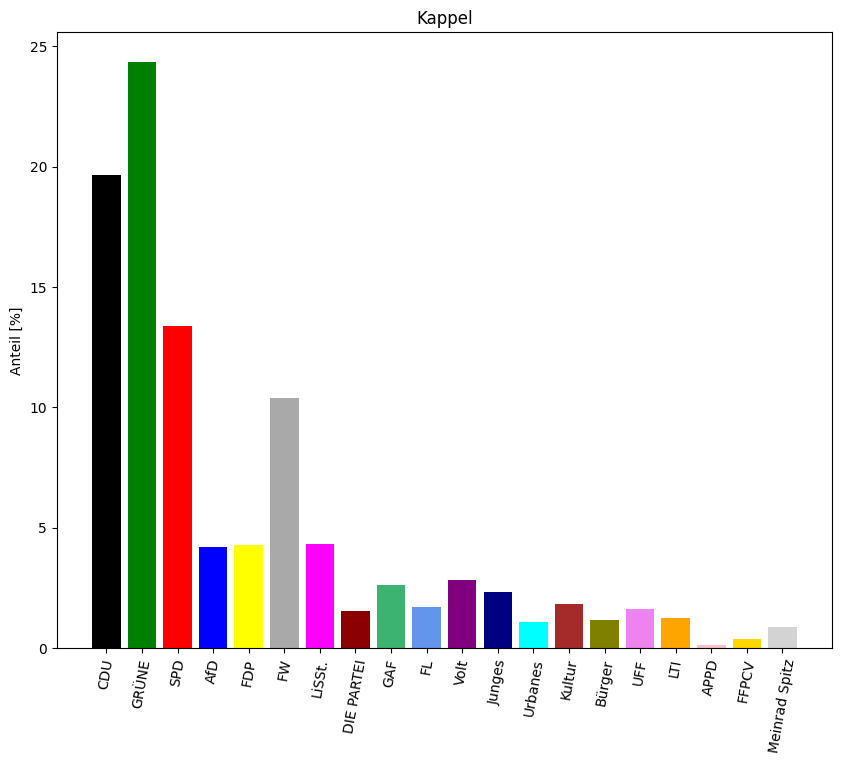

In [17]:
print("Prozent in 2024")
print(100*(comb2[(comb2.index=='Kappel')].loc[:,['CDU','SPD','GRÜNE','FW','AfD','FDP']])/np.array(comb2[(comb2.index=='Kappel')].loc[:,['Gueltige_Stimmen']]))

make_bar_plot(comb2,index='Kappel',title='Kappel')

Vergliechen mit 2019, habane die Freien Waehler 5.4% gewonnen, die CDU 1.5% gewonnen, die SPD 0.1% verloren und die Gruenen 5.1% verloren. 

Nun Verwendung der Wahlbezirke der Europawahl. Das hat den Vorteil, dass die Wahlbezirke genau die selben waren und man so auf die nur teilweise ausgezaehlten Stadtbezirke verwenden kann. 

In [18]:
eu_wahlbezirke=pd.read_csv('eu24_wahlbezirke.csv',sep=';')
wahl_bezirke=get_percent(wahl_bezirke)

eu_wahlbezirke=get_percent(eu_wahlbezirke,wahl='Europa')
com_wahlbezirke=pd.merge(wahl_bezirke,eu_wahlbezirke, how='inner', left_on='gebiet-nr',right_on='gebiet-nr',suffixes=('_gem24', '_eu24'))

In [69]:
def linf(x,a,b):
    return a+x*b

Ich verwende den unterschied zu anderen Stimmen hierbei, durch den Korrelations coeffeicent verwende ich den besten Partner. Das ist in der Regel eine Grosse Partei, da bei mehrr Stimmen, das Rauschen kleiner ist. 

In [20]:
tot_eu=pd.read_csv('eu24_summe.csv',sep=';')
partei_gem=['CDU',
       'GRÜNE', 'SPD', 'AfD', 'FDP', 'FW', 'LiSSt.', 'DIE_PARTEI', 'GAF',
       'FL', 'Volt', 'Junges_F', 'Urbanes_F', 'Kultur', 'Bürger_F',
       'UFF', 'LTI', 'APPD', 'FFPCV', 'Meinrad_Spitz']
col=partei_gem[0]
sel=com_wahlbezirke[(com_wahlbezirke[col].isna()==False)]
resp=np.zeros((len(partei_gem)+1))
for j in range(len(partei_gem)):
    party=partei_gem[j]
    col=party+'_prozent_gem24'
    parteien=[ 'CDU',
       'GRÜNE', 'SPD', 'AfD', 'FDP', 'FW', 'LINKE', 'DIE_PARTEI', 'Tierschutz',
       'ÖDP', 'Volt', 'Piraten', 'Familien', 'MERA25', 'Bündnis_C',
       'Aktion_Tierschutz', 'BIG', 'HEIMAT', 'PdH', 'PfSV', 'MW', 'MLPD',
       'DKP', 'SGP', 'ABG', 'dieBasis', 'B_Deutschland', 'BSW', 'DAVA',
       'Klimaliste', 'Letzte_Generation', 'PDV', 'PdF', 'PVVV']
    corrs=np.zeros((len(parteien)))
    for i in range(len(parteien)):
        ar=np.zeros((2,sel.shape[0]))
        ar[0]=sel[parteien[i]+'_prozent_eu24']
        ar[1]=sel[party+'_prozent_gem24']-sel[parteien[i]+'_prozent_eu24']
        corr=np.corrcoef(ar[0],ar[1])
        corrs[i]=np.abs(corr[0,1])
    s=np.argmax(corrs)
    print(f"Fuer Liste {party} EU {parteien[s]} has the biggest |corr| of {corrs[s]}")
    ar[0]=sel[parteien[s]+'_prozent_eu24']
    ar[1]=sel[party+'_prozent_gem24']-sel[parteien[s]+'_prozent_eu24']
    res,cov=sp.optimize.curve_fit(linf,ar[0],ar[1])
    eu_anteil=np.array(tot_eu[parteien[s]]/tot_eu['Gueltige_Stimmen'])*100
    gem_anteil=linf(eu_anteil,res[0],res[1])+eu_anteil
    resp[j]=gem_anteil
resp[0:-1]=resp[0:-1]/np.sum(resp)*tot_eu.Gueltige_Stimmen[0]*3
resp[-1]=np.sum(resp)
partei_gem.append('Gueltige_Stimmen')
prediction=pd.DataFrame(data=resp,index=partei_gem).T
print("Vorhergesage Prozent Zahlen")
print((100*prediction/prediction.loc[0,'Gueltige_Stimmen']).T)

Fuer Liste CDU EU GRÜNE has the biggest |corr| of 0.9284784065584427
Fuer Liste GRÜNE EU AfD has the biggest |corr| of 0.9311540073713254
Fuer Liste SPD EU GRÜNE has the biggest |corr| of 0.9801051686952971
Fuer Liste AfD EU GRÜNE has the biggest |corr| of 0.9475975066615117
Fuer Liste FDP EU GRÜNE has the biggest |corr| of 0.9784674080326796
Fuer Liste FW EU GRÜNE has the biggest |corr| of 0.9129288603008544
Fuer Liste LiSSt. EU CDU has the biggest |corr| of 0.9872887927063905
Fuer Liste DIE_PARTEI EU GRÜNE has the biggest |corr| of 0.9919114972913493
Fuer Liste GAF EU CDU has the biggest |corr| of 0.9940173354206874
Fuer Liste FL EU GRÜNE has the biggest |corr| of 0.9949695369363074
Fuer Liste Volt EU CDU has the biggest |corr| of 0.9922697384866517
Fuer Liste Junges_F EU CDU has the biggest |corr| of 0.9934085758120004
Fuer Liste Urbanes_F EU CDU has the biggest |corr| of 0.9932158763219928
Fuer Liste Kultur EU GRÜNE has the biggest |corr| of 0.992300542770049
Fuer Liste Bürger_F EU

Vergliechen zu 2019 gewann die CDU 2.9%, die Freien Waehler 3.4%, waehrend Grune 4.4% verloren, und SPD 0.3% und Liste Linke verloren 0.3%.  

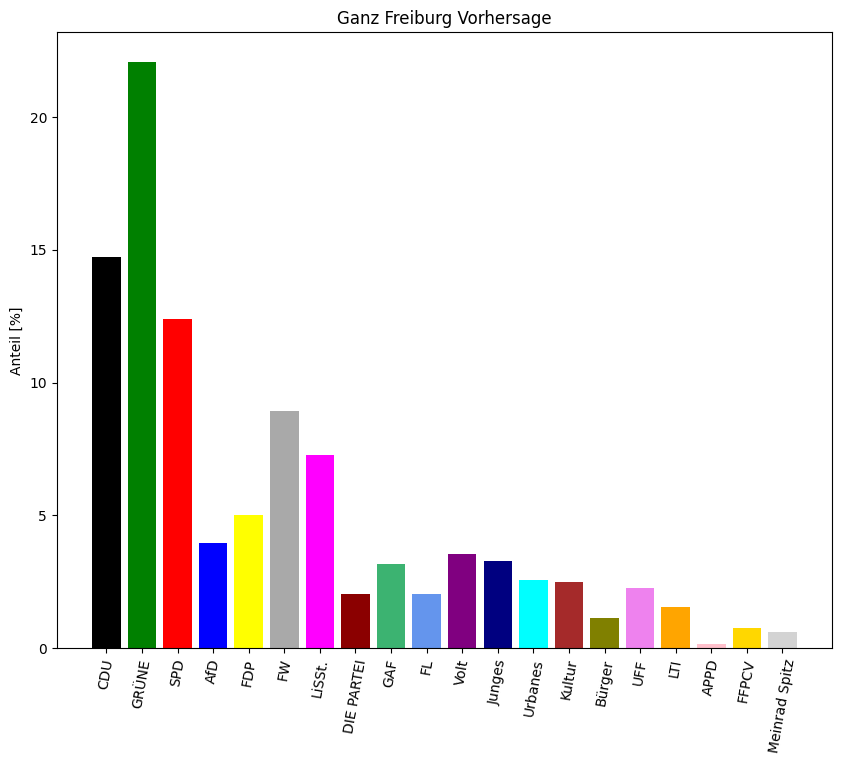

In [21]:
make_bar_plot(prediction,title='Ganz Freiburg Vorhersage')

Und zu dieser in Mitgliedern. 

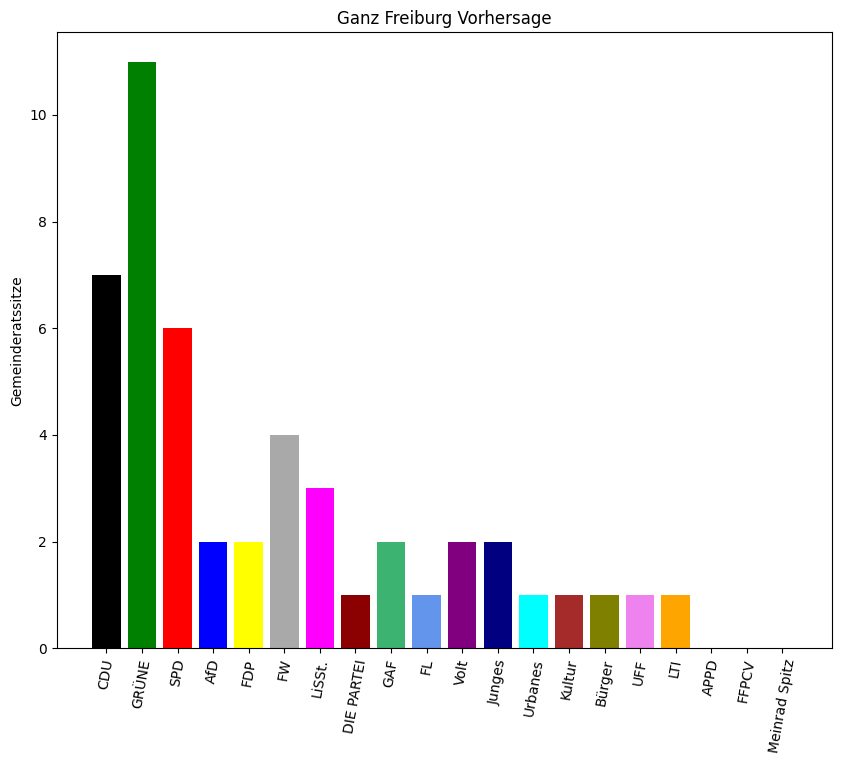

In [22]:
make_bar_plot(prediction,title='Ganz Freiburg Vorhersage',sitze=48)

Vergliechen mit dem Auszaehlungsstand am 10.6 gewinnen GAF, Volt und Junges Freiburg ein Mandat waehrend CDU, AfD und Freie Waehler jeweils eines verlieren. 

Vergliechen mit 2019 verlieren die Gruenen 2, die Gruene Alternative Freiburg und Freiburg Lebenswert jeweils eines. 

Die CDU und die freien Waehler gewinnt eines, und die neue List Volt 2. 

Die Anderen bleiben unveraendert. 
